In [1]:
import os, importlib, sys, time

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import scipy.linalg as la
import scipy.stats as stats

In [4]:
import pyarrow

In [5]:
import freqepid

# 1. parameters

In [6]:
GPi = np.load('data/GPi.npz')

## observation parameters

In [7]:
r_Y = 10

$$Y_t = NegBinom( \frac{EY_t}{r_Y + EY_t}, r_Y )$$

$$ EY_t = \alpha\sum_{s=1}^{t-1} I_s \pi_{t-s} $$

## latent parameters

In [8]:
d = 2

$$I_t = NegBinom( \frac{EI_t}{r_I + EI_t}, r_I )$$

$$ EI_t = R(\bar{A}_t, \beta) \sum_{s=1}^{t-1} I_s g_{t-s} $$

$$R(\bar{A}_t, \beta) = \frac{K}{1+\exp(- \beta^\top A_t)}$$

## seed values

$$I_{[-T_0,0)} = \mu_0$$

## model

In [9]:
model = freqepid.Model(GPi['g'], GPi['pi'], T0=40, family='nbinom')

# 2. simulation

## random seed

In [10]:
np.random.seed(1111)

## parameter generation

In [11]:
num_region = 100

In [12]:
Ts = np.random.uniform(55, 65, num_region).astype(int)

In [13]:
T1s = np.random.uniform(17, 23, num_region).astype(int)

In [14]:
regions = np.repeat(np.arange(num_region), Ts)

In [42]:
theta_o = np.array([[np.log(150), 0.5, -2.5],
                    [np.log(600), -0.5, -1.5]])

In [64]:
zeta = np.random.normal(0,1,size=(num_region,3))
eps = 0.2 * zeta @ la.sqrtm([[1, 0, 0], [0, 0.5, -0.25], [0, -0.25, 0.5]])
thetas = theta_o[np.random.choice(2, num_region, True),:] + eps

(array([ 7., 19., 16.,  4.,  1.,  0.,  6., 21., 17.,  9.]),
 array([-2.85720973, -2.68563452, -2.51405932, -2.34248412, -2.17090891,
        -1.99933371, -1.82775851, -1.6561833 , -1.4846081 , -1.3130329 ,
        -1.14145769]),
 <BarContainer object of 10 artists>)

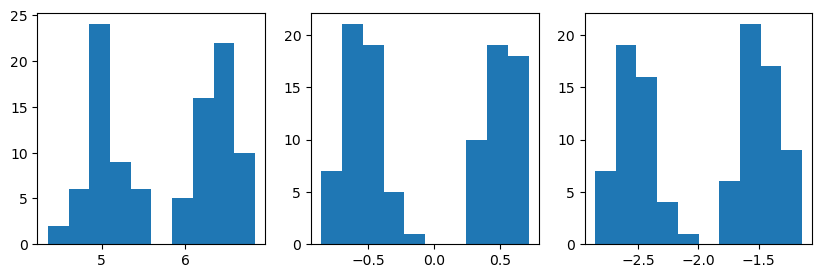

In [65]:
plt.figure(figsize=(10,3))
plt.subplot(1,3,1); plt.hist(thetas[:,0])
plt.subplot(1,3,2); plt.hist(thetas[:,1])
plt.subplot(1,3,3); plt.hist(thetas[:,2])

## data generateion

In [66]:
As = [
    np.stack([np.full(T, 1), 1 * (np.arange(T) > T1)], -1)
    for T, T1 in zip(Ts, T1s)
]

In [67]:
Rs = [
    model.predict_R(A, th[1:])
    for A, th in zip(As, thetas)
]

In [68]:
Is = [
    model.predict_I(A, th[0], th[1:])
    for A, th in zip(As, thetas)
]

In [69]:
EYs = [
    model.predict_EY(A, th[0], th[1:])
    for A, th in zip(As, thetas)
]

In [70]:
Ys = [
    np.random.negative_binomial(r_Y, r_Y/(r_Y+EY))
    for EY in EYs
]

## result

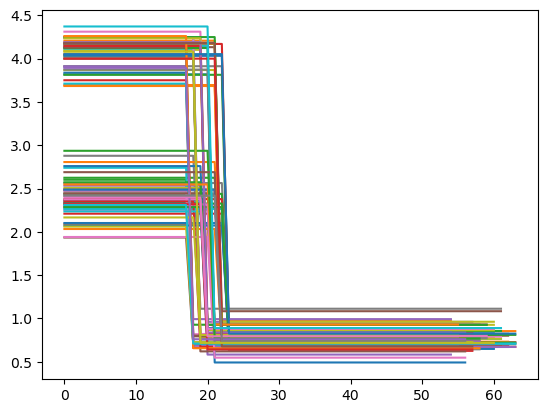

In [71]:
for R in Rs:
    plt.plot(R)

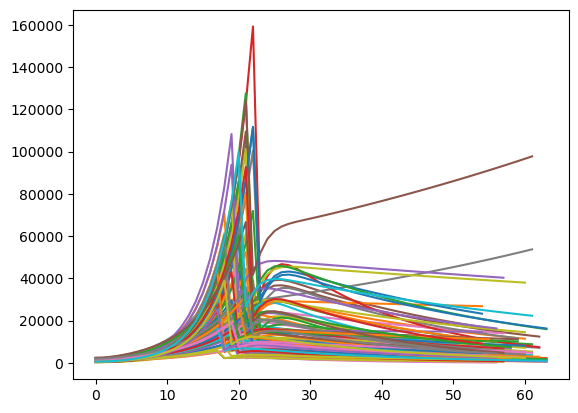

In [72]:
for I in Is:
    plt.plot(I)

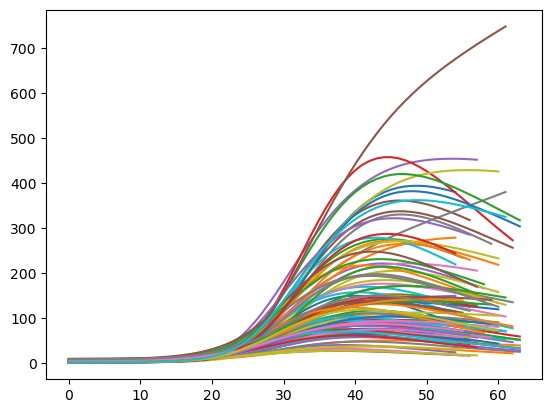

In [73]:
for EY in EYs:
    plt.plot(EY)

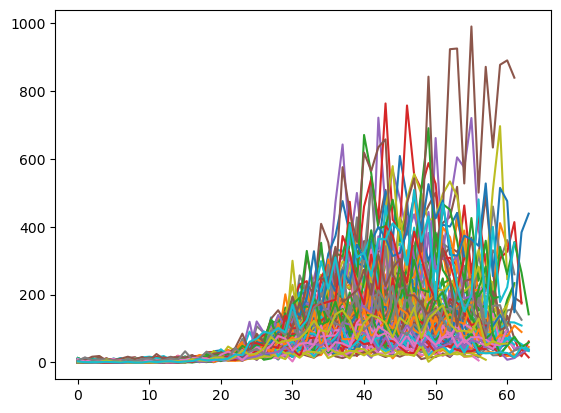

In [74]:
for Y in Ys:
    plt.plot(Y)

# 3. Save Data

In [75]:
from string import ascii_lowercase
from itertools import product

region_names = np.array([
    ''.join(combo) for combo in product(ascii_lowercase, repeat=2)
])

In [76]:
data = {'region': region_names[np.repeat(np.arange(num_region), Ts)],
        'date': np.concatenate([np.arange(T) for T in Ts]),
        'R': np.concatenate(Rs),
        'EI': np.concatenate(Is),
        'infection': np.concatenate(Is),
        'EY': np.concatenate(EYs),
        'death': np.concatenate(Ys),
        'intervention': np.concatenate(As, 0)[:,1]}

In [77]:
df = pd.DataFrame(data)

In [78]:
df

,region,date,R,EI,infection,EY,death,intervention
0,aa,0,3.83775,614.461723,614.461723,1.530772,1,0
1,aa,1,3.83775,646.418102,646.418102,1.541138,2,0
2,aa,2,3.83775,764.782524,764.782524,1.550349,1,0
3,aa,3,3.83775,958.980489,958.980489,1.559102,1,0
4,aa,4,3.83775,1220.648612,1220.648612,1.569473,3,0
...,...,...,...,...,...,...,...,...
5926,dv,57,0.88899,23847.672976,23847.672976,341.600895,134,1
5927,dv,58,0.88899,23457.591709,23457.591709,337.524570,400,1
5928,dv,59,0.88899,23073.891081,23073.891081,333.310910,178,1
5929,dv,60,0.88899,22696.466723,22696.466723,328.921328,222,1


In [79]:
df.to_feather('data/simulation_ebcr_2.feather')

In [80]:
param = {'region': region_names[np.arange(num_region)],
         'mu': thetas[:,0],
         'beta[0]': thetas[:,1],
         'beta[1]': thetas[:,2]}

In [81]:
df_param = pd.DataFrame(param)

In [82]:
df_param.to_feather('data/param_ebcr_2.feather')

(-4.0, 0.0)

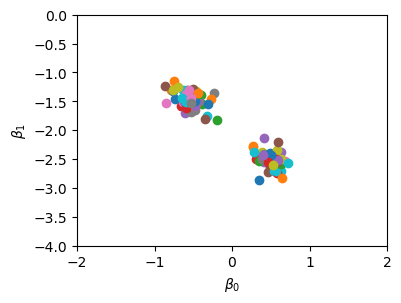

In [87]:
plt.figure(figsize=(4,3))
for i_region, theta in enumerate(thetas):
    p = plt.scatter(*(theta[1:]))
plt.xlabel(r"$\beta_0$"); plt.ylabel(r"$\beta_1$")
plt.xlim([-2, 2]); plt.ylim([-4, 0])

In [85]:
np.cov(thetas.T)

array([[ 0.50947668, -0.35593176,  0.35654211],
       [-0.35593176,  0.2946689 , -0.28330794],
       [ 0.35654211, -0.28330794,  0.29525151]])